#### Member Tim:

* Qothrunnadaa Alyaa ( Data Analyst )

* Athalla Rafly Mahardhika Noegroho ( Data Scientist )

* Habibi Bagus Suliano ( Data Scientist )

* Achmad Dhani ( Data Engineer )

PIC: Athalla Rafly & Habibi Bagus

### Objective
Tujuan utamanya adalah membangun sebuah model menggunakan pendekatan NLP untuk mengkategorikan ulasan produk ke dalam sentimen positif atau negatif. Model ini akan dievaluasi menggunakan metrik akurasi sebagai tolok ukur utama untuk menilai seberapa tepatnya model dalam memprediksi sentimen dari ulasan produk. Tingkat akurasi yang tinggi akan menjadi indikator keberhasilan, menunjukkan kemampuan model dalam mengklasifikasikan sentimen dengan akurat.

**melakukan penginstalan modul yang diperlukan**

In [1]:
!pip install pysastrawi

In [2]:
!pip install nlp-id

# Import Libraries

In [3]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nlp_id.stopword import StopWord
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nlp_id.lemmatizer import Lemmatizer

nltk.download('stopwords')
nltk.download('punkt')

from tensorflow.keras.layers import TextVectorization, Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Loading

melakukan mounting google drive karena mengerjakan di google collab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load Data
data = pd.read_csv('/content/drive/MyDrive/PRDECT-ID Dataset.csv')
data.head(5)

,Category,Product Name,Location,Price,Overall Rating,Number Sold,Total Review,Customer Rating,Customer Review,Sentiment,Emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         5400 non-null   object 
 1   Product Name     5400 non-null   object 
 2   Location         5400 non-null   object 
 3   Price            5400 non-null   int64  
 4   Overall Rating   5400 non-null   float64
 5   Number Sold      5400 non-null   int64  
 6   Total Review     5400 non-null   int64  
 7   Customer Rating  5400 non-null   int64  
 8   Customer Review  5400 non-null   object 
 9   Sentiment        5400 non-null   object 
 10  Emotion          5400 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 464.2+ KB


In [7]:
data.describe(include='O')

,Category,Product Name,Location,Customer Review,Sentiment,Emotion
count,5400,5400,5400,5400,5400,5400
unique,29,1308,61,5305,2,5
top,Computers and Laptops,Minigold Black Series Logam Mulia Koin Emas Mi...,Jakarta Barat,Kualitas Produk Bagus.,Negative,Happy
freq,200,25,1293,4,2821,1770


# Feature Engineering

#### **Check Duplicate**

In [9]:
# Cek data duplikat
data.duplicated().sum()

7

terlihat ada data duplicate oleh karena itu akan dilakukan handling

In [10]:
data_duplicates = data.drop_duplicates(keep='first')

bertujuan untuk menghapus baris data yang merupakan duplikat dari dataset data, dan hanya mempertahankan baris pertama dari duplikat tersebut dengan parameter keep='first'.

In [11]:
data_duplicates.duplicated().sum()

0

terlihat diatas tidak ada misiing value didalam dataset oleh karena itu tidak perlu di handling

In [12]:
# Mengganti spasi menjadi garis bawah (_) dan merubah nama kolom menjadi lowercase pada DataFrame data_duplicates
data_duplicates.columns = data_duplicates.columns.str.replace(' ', '_').str.lower()
data_duplicates.head(5)

,category,product_name,location,price,overall_rating,number_sold,total_review,customer_rating,customer_review,sentiment,emotion
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy


Hasilnya diatas adalah DataFrame baru yang memiliki nama kolom yang diubah. Dengan mengganti spasi menjadi garis bawah dan merubah ke huruf kecil, ini dapat memudahkan proses pemrosesan data dan analisis lebih lanjut.

In [13]:
data_cleaned = data_duplicates.copy()

#### **Handling Missing value**

In [14]:
# Cek missing values
data_cleaned[data_cleaned[['sentiment', 'customer_review']].isnull().any(axis=1)]

,category,product_name,location,price,overall_rating,number_sold,total_review,customer_rating,customer_review,sentiment,emotion


melakukan pemeriksaan terhadap nilai yang hilang (missing values) pada kolom 'sentiment' dan 'customer_review' dalam DataFrame 

#### **Pre-processing Reviews: Checking Mentions and Hashtags**

In [15]:
# Mencari mention dalam review_text
data_cleaned['customer_review'].loc[data_cleaned['customer_review'].str.contains(r"@[A-Za-z0-9_]+")].to_frame()

,customer_review


menampilkan baris-baris dari kolom 'customer_review' yang mengandung mention (atau tag) yang diawali dengan simbol '@' dalam DataFrame data_cleaned.

In [16]:
# Define Stopwords
stopwords_id = set(stopwords.words('indonesian'))
sw_1 = set(StopWordRemoverFactory().get_stop_words())
sw_2 = set(StopWord().get_stopword())
stopwords_id.update(sw_1)
stopwords_id.update(sw_2)
add_sw = {'tp', 'jg', 'tgl', 'utk', 'nya', 'yg', 'sih', 'aja', 'lg', 'barang', 'tokopedia', 'tokped', 'toped', 'tokopeda',
          'an', 'aaaa', 'hehe', 'laaah', 'yaa', 'krn', 'sy', 'dgn', 'dg', 'sdh', 'jd', 'brg', 'dapet', 'dah', 'sen',
          'gan', 'ny', 'kak', 'dpt', 'deh', 'udh', 'dr', 'dg', 'da', 'uda', 'nih', 'gw', 'gin', 'pdhl', 'duh', 'yah', 'loh',
          'lo', 'jual', 'seller', 'toko', 'sesuai', 'produk', 'pakai', 'pake', 'dtg', 'jgn', 'rb', 'eh',
          'sya', 'tuh', 'klo', 'bs', 'wa', 'gr', 'spt', 'ps', 'lbh', 'pcs', 'pc', 'blm', 'dlm', 'cpt', 'hr', 'eh', 'knp','pd',
          'sm', 'jdi', 'bbrp', 'sma', 'sprti', 'kyk', 'ad'}
remove_sw = {'tidak', 'kurang', 'akurat', 'seenaknya', 'masalahnya', 'segitu', 'sepihak', 'lama', 'pihak', 'alhamdulillah',
             'percuma', 'makasih', 'kelamaan', 'keterlaluan', 'tepat', 'berkali', 'sekali', 'macam', 'kesekian', 'baik',
             'waktu', 'cukup', 'bisa', 'banyak', 'biasa', 'baru', 'jelas', 'sesuai', 'sampai', 'tapi', 'betul', 'datang',
             'masalah', 'banget', 'apa', 'kali', 'kesekian'}
stopwords_id.update(add_sw)
stopwords_id.difference_update(remove_sw)

mengumpulkan stopwords, kemudian menggabungkannya dan melakukan penambahan serta pengurangan kata-kata tertentu.

In [17]:
# Define lemmatizer
lemmatizer = Lemmatizer()


# Definisikan fungsi untuk memproses teks

def text_preprocessing(text, stop_words, lemmatizer):

    # Case folding
    text = text.lower()

    # Menghapus special character
    text = re.sub(r"[^a-zA-Z\s\']", " ", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Mengganti kata 'ga', 'gak', 'ngga', 'gk', dan 'tdk' menjadi 'tidak'
    tokens = [word if word.lower() not in {'ga', 'gak', 'ngga', 'gk', 'tdk'} else 'tidak' for word in tokens]

    # Mengganti variasi dari kata mantap
    tokens = [word if word.lower() not in {'manstapu', 'mantappp', 'mantabbb', 'mantappss', 'mantaaaap', 'mantappppp', 'mantab'} else 'mantap' for word in tokens]

    # Mengganti variasi kata banget
    tokens = [word if word.lower() not in {'bangett', 'bangettt', 'bgt'} else 'banget' for word in tokens]

    # Mengganti variasi kata bagus
    tokens = [word if word.lower() not in {'bagusss', 'baguss', 'bgs'} else 'bagus' for word in tokens]

    tokens = [word if word.lower() not in {'gpp'} else 'tidak apa-apa' for word in tokens]

    tokens = [word if word.lower() not in {'hrg'} else 'harga' for word in tokens]

    tokens = [word if word.lower() not in {'terimakasih'} else 'terima kasih' for word in tokens]

    # Lemmatizer untuk mengembalikan kata menjadi bentuk dasarnya
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Menghapus stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Menggabungkan tokens
    processed_text = ' '.join(tokens)

    return processed_text

# Mengaplikasikan fungsi text preprocessing pada review_text
data_cleaned['review_processed'] = data_cleaned['customer_review'].apply(lambda review: text_preprocessing(review, stopwords_id, lemmatizer))
data_cleaned

,category,product_name,location,price,overall_rating,number_sold,total_review,customer_rating,customer_review,sentiment,emotion,review_processed
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy,fungsi packaging aman respon cepat ramah kurir...
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy,respon cepat harga saing
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy,fungsi seler ramah cepat
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy,harap ramah trimakasih lapak
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy,kemas aman fungsi
...,...,...,...,...,...,...,...,...,...,...,...,...
5395,Household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,Jakarta Pusat,35000,4.9,1431,562,5,"Harga bersaing, barang sesuai pesanan. Saya na...",Positive,Love,harga saing nambah extra packing kardus bubble...
5396,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Beli ini krn Anak & Istri mau liburan di Jakar...,Positive,Love,anak istri libur jakarta cari ketemu harga ram...
5397,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,"pengemasan barang baik, kondisi barang jg utuh...",Positive,Happy,kemas kondisi utuh cacat fungsi normal lancar ...
5398,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Mungil tapi bekerja dng baik. Dan murahh terja...,Positive,Happy,mungil dng murahh jangkau dng butuh


pra-pemrosesan teks yang lengkap untuk membersihkan, normalisasi, dan mengelola teks ulasan pelanggan. seperti penghilangan karakter khusus, tokenisasi kata, penggantian variasi kata tertentu dengan kata standar, penggunaan lemmatizer untuk mengembalikan kata ke bentuk dasarnya, dan penghapusan stopwords.

In [18]:
# Mengaplikasikan fungsi text preprocessing pada review_text
data_cleaned['review_processed'] = data_cleaned['customer_review'].apply(lambda review: text_preprocessing(review, stopwords_id, lemmatizer))
data_cleaned

,category,product_name,location,price,overall_rating,number_sold,total_review,customer_rating,customer_review,sentiment,emotion,review_processed
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy,fungsi packaging aman respon cepat ramah kurir...
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy,respon cepat harga saing
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy,fungsi seler ramah cepat
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy,harap ramah trimakasih lapak
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy,kemas aman fungsi
...,...,...,...,...,...,...,...,...,...,...,...,...
5395,Household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,Jakarta Pusat,35000,4.9,1431,562,5,"Harga bersaing, barang sesuai pesanan. Saya na...",Positive,Love,harga saing nambah extra packing kardus bubble...
5396,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Beli ini krn Anak & Istri mau liburan di Jakar...,Positive,Love,anak istri libur jakarta cari ketemu harga ram...
5397,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,"pengemasan barang baik, kondisi barang jg utuh...",Positive,Happy,kemas kondisi utuh cacat fungsi normal lancar ...
5398,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Mungil tapi bekerja dng baik. Dan murahh terja...,Positive,Happy,mungil dng murahh jangkau dng butuh


In [24]:
data_cleaned['sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

In [25]:
label_encoder = LabelEncoder()
data_cleaned['sentiment_encode'] = label_encoder.fit_transform(data_cleaned['sentiment'])
data_cleaned

,category,product_name,location,price,overall_rating,number_sold,total_review,customer_rating,customer_review,sentiment,emotion,review_processed,sentiment_encode
0,Computers and Laptops,Wireless Keyboard i8 Mini TouchPad Mouse 2.4G ...,Jakarta Utara,53500,4.9,5449,2369,5,Alhamdulillah berfungsi dengan baik. Packaging...,Positive,Happy,fungsi packaging aman respon cepat ramah kurir...,1
1,Computers and Laptops,PAKET LISENSI WINDOWS 10 PRO DAN OFFICE 2019 O...,Kota Tangerang Selatan,72000,4.9,2359,1044,5,"barang bagus dan respon cepat, harga bersaing ...",Positive,Happy,respon cepat harga saing,1
2,Computers and Laptops,SSD Midasforce 128 Gb - Tanpa Caddy,Jakarta Barat,213000,5.0,12300,3573,5,"barang bagus, berfungsi dengan baik, seler ram...",Positive,Happy,fungsi seler ramah cepat,1
3,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,bagus sesuai harapan penjual nya juga ramah. t...,Positive,Happy,harap ramah trimakasih lapak,1
4,Computers and Laptops,ADAPTOR CHARGER MONITOR LCD LED TV LG merek LG...,Jakarta Timur,55000,4.7,2030,672,5,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Positive,Happy,kemas aman fungsi,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,Household,PCK-01 Penjepit Barang / Pickup Tool Ver.1 Ala...,Jakarta Pusat,35000,4.9,1431,562,5,"Harga bersaing, barang sesuai pesanan. Saya na...",Positive,Love,harga saing nambah extra packing kardus bubble...,1
5396,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Beli ini krn Anak & Istri mau liburan di Jakar...,Positive,Love,anak istri libur jakarta cari ketemu harga ram...,1
5397,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,"pengemasan barang baik, kondisi barang jg utuh...",Positive,Happy,kemas kondisi utuh cacat fungsi normal lancar ...,1
5398,Household,Ultrasonic Aroma Diffuser Humidifier Colorful ...,Jakarta Utara,99000,4.9,15529,4074,5,Mungil tapi bekerja dng baik. Dan murahh terja...,Positive,Happy,mungil dng murahh jangkau dng butuh,1


LabelEncoder untuk mengubah kolom sentimen yang bersifat teks menjadi representasi numerik.

In [26]:
data_cleaned['sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

In [27]:
data_cleaned['sentiment_encode'].unique()

array([1, 0])

Positif  = 1  
Negative = 0  

#### **Split Train and Test**

In [33]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(data_cleaned.review_processed,
                                                            data_cleaned.sentiment_encode,
                                                            test_size=0.20,
                                                            random_state=7,
                                                            stratify=data_cleaned.sentiment_encode)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=88,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (3882,)
Val Size   :  (432,)
Test Size  :  (1079,)



dataset telah dibagi dengan baik menjadi bagian pelatihan, validasi, dan pengujian sesuai proporsi yang telah ditentukan. Proporsi ini memungkinkan model untuk dilatih, divalidasi, dan diuji pada dataset yang terpisah, yang dapat meningkatkan kehandalan evaluasi dan kinerja model yang akan dikembangkan.

In [34]:
# Mencari vocabulary dengan CountVectorizer

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<3882x5063 sparse matrix of type '<class 'numpy.int64'>'
	with 26116 stored elements in Compressed Sparse Row format>

CountVectorizer untuk mengubah teks menjadi representasi vektor numerik.

In [36]:
# Mencari jumlah vocabulary dan panjang maksimum suatu kalimat (token)

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocabularies : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocabularies :  5063
Maximum Sentence Length :  91 tokens


Pada kode diatas, dilakukan perhitungan terkait jumlah total kata dalam kamus atau vocabulary yang dihasilkan oleh CountVectorizer dan panjang maksimum suatu kalimat dalam data latih.

In [37]:
# Check a sample of the processed text data
print(data_cleaned['review_processed'].head())

# Check a sample of the tokenized data
tokens_sample = Vectorize.get_feature_names_out()[:10]
print(tokens_sample)

# Check a sample of the transformed data
print(X_train_vec[:5])

0    fungsi packaging aman respon cepat ramah kurir...
1                             respon cepat harga saing
2                             fungsi seler ramah cepat
3                         harap ramah trimakasih lapak
4                                    kemas aman fungsi
Name: review_processed, dtype: object
['aa' 'aaa' 'aamiin' 'aamiinn' 'ab' 'abai' 'abal' 'abang' 'abbot' 'abc']
  (0, 3322)	1
  (0, 136)	1
  (0, 1501)	1
  (1, 826)	1
  (1, 3191)	1
  (1, 4520)	1
  (1, 207)	1
  (1, 2113)	1
  (1, 4797)	1
  (1, 4947)	1
  (1, 625)	1
  (1, 2535)	1
  (2, 2116)	1
  (2, 2332)	1
  (2, 598)	1
  (2, 108)	1
  (2, 3935)	1
  (2, 1328)	1
  (2, 878)	1
  (3, 3325)	1
  (3, 3740)	1
  (4, 2116)	1
  (4, 3935)	1


In [38]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=20,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

In [39]:
# Embedding

embedding = Embedding(input_dim=total_vocab,
                            output_dim=100,
                            input_length=20)

# Model Definition

Membuat model LSTM, GRU, CNN, RNN untuk Mencari tahu model mana yang paling bagus

#### LSTM 1

In [40]:
# Model LSTM - 1

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

## Arsitektur
lstm_1 = Sequential()
lstm_1.add(text_vectorization)
lstm_1.add(embedding)
lstm_1.add(Bidirectional(LSTM(50, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_1.add(Dropout(0.2))
lstm_1.add(Bidirectional(LSTM(25, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_1.add(Dropout(0.1))
lstm_1.add(Bidirectional(LSTM(5, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_1.add(Dropout(0.1))
lstm_1.add(Dense(1, activation='sigmoid'))

# Compile
lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 100)           506300    
                                                                 
 bidirectional (Bidirection  (None, 20, 100)           60400     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 20, 100)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 50)            25200     
 onal)                                                           
                                                        

#### LSTM 2

In [41]:
# Model LSTM - 2

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur
lstm_2 = Sequential()

lstm_2.add(text_vectorization)
lstm_2.add(embedding)

lstm_2.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_2.add(Dropout(0.5))

lstm_2.add(Bidirectional(LSTM(8, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_2.add(Dropout(0.2))

lstm_2.add(Bidirectional(LSTM(4, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_2.add(Dropout(0.1))

lstm_2.add(Dense(1, activation='sigmoid'))

# Compile
lstm_2.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Summary
lstm_2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 100)           506300    
                                                                 
 bidirectional_3 (Bidirecti  (None, 20, 32)            14976     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 20, 32)            0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 20, 16)            2624      
 onal)                                                           
                                                      

#### RNN

In [42]:
# Model Simple RNN

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur
rnn = Sequential()
rnn.add(text_vectorization)
rnn.add(embedding)

rnn.add(Bidirectional(SimpleRNN(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.6))
rnn.add(Bidirectional(SimpleRNN(8, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.4))
rnn.add(BatchNormalization())
rnn.add(Bidirectional(SimpleRNN(8, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.2))
# rnn.add(BatchNormalization())

rnn.add(Bidirectional(SimpleRNN(4, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
rnn.add(Dropout(0.1))

rnn.add(Dense(1, activation='sigmoid'))

# Compile
rnn.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0), metrics='accuracy')
# rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Model Checkpoint
model_checkpoint = ModelCheckpoint('model_rnn', monitor='val_accuracy', save_best_only=True,mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Summary
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 100)           506300    
                                                                 
 bidirectional_6 (Bidirecti  (None, 20, 32)            3744      
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 20, 32)            0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 20, 16)            656       
 onal)                                                           
                                                      

#### GRU

In [43]:
# Model GRU

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur
gru = Sequential()
gru.add(text_vectorization)
gru.add(embedding)
gru.add(Bidirectional(GRU(50, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
gru.add(Dropout(0.1))
gru.add(Bidirectional(GRU(50, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
gru.add(Dropout(0.1))
gru.add(Bidirectional(GRU(25, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
gru.add(Dense(1, activation='sigmoid'))

# Compile
gru.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

# Summary
gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 100)           506300    
                                                                 
 bidirectional_10 (Bidirect  (None, 20, 100)           45600     
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 20, 100)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 20, 100)           45600     
 ional)                                                          
                                                      

#### LSTM updated

In [44]:
# Model LSTM - Updated

seed = 20
np.random.seed(seed)
tf.random.set_seed(seed)

# Architecture
lstm_further_updated = Sequential()

lstm_further_updated.add(text_vectorization)
lstm_further_updated.add(embedding)

lstm_further_updated.add(Bidirectional(LSTM(10, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_further_updated.add(Dropout(0.3))  # Increase dropout rate

lstm_further_updated.add(Bidirectional(LSTM(5, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_further_updated.add(Dropout(0.2))  # Increase dropout rate

lstm_further_updated.add(Bidirectional(LSTM(1, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
lstm_further_updated.add(Dropout(0.1))  # Increase dropout rate

lstm_further_updated.add(Dense(1, activation='sigmoid'))

# Compile with ReduceLROnPlateau
lstm_further_updated.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics='accuracy')

# Learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Summary
lstm_further_updated.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 100)           506300    
                                                                 
 bidirectional_13 (Bidirect  (None, 20, 20)            8880      
 ional)                                                          
                                                                 
 dropout_12 (Dropout)        (None, 20, 20)            0         
                                                                 
 bidirectional_14 (Bidirect  (None, 20, 10)            1040      
 ional)                                                          
                                                      

#### CNN

In [45]:
tf.keras.backend.clear_session()

model_cnn_reg = Sequential([
    text_vectorization,
    embedding,
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=4, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='linear')
], name='CNN')
model_cnn_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Model summary
model_cnn_reg.summary()

# Model checkpoint
cnn_checkpoint = ModelCheckpoint('cnn', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 20)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 20, 100)           506300    
                                                                 
 conv1d (Conv1D)             (None, 20, 256)           77056     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           131200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 128)            0       

# Model Training

Melatih model yang sudah dibuat diatas untuk mengetahui model mana yang paling bagus

In [46]:
# Training model LSTM 1

lstm_hist = lstm_1.fit(X_train, y_train, epochs=30, batch_size=125, validation_data=(X_val, y_val))

Epoch 1/30
32/32 [==============================] - 21s 189ms/step - loss: 0.6493 - accuracy: 0.6530 - val_loss: 0.4446 - val_accuracy: 0.8542
Epoch 2/30
32/32 [==============================] - 3s 108ms/step - loss: 0.3628 - accuracy: 0.8800 - val_loss: 0.3371 - val_accuracy: 0.8681
Epoch 3/30
32/32 [==============================] - 6s 177ms/step - loss: 0.2211 - accuracy: 0.9356 - val_loss: 0.3232 - val_accuracy: 0.8750
Epoch 4/30
32/32 [==============================] - 4s 137ms/step - loss: 0.1574 - accuracy: 0.9557 - val_loss: 0.3595 - val_accuracy: 0.8611
Epoch 5/30
32/32 [==============================] - 3s 106ms/step - loss: 0.1173 - accuracy: 0.9647 - val_loss: 0.4356 - val_accuracy: 0.8588
Epoch 6/30
32/32 [==============================] - 3s 104ms/step - loss: 0.1068 - accuracy: 0.9691 - val_loss: 0.3641 - val_accuracy: 0.8634
Epoch 7/30
32/32 [==============================] - 5s 174ms/step - loss: 0.0896 - accuracy: 0.9714 - val_loss: 0.4091 - val_accuracy: 0.8611
Epoch

In [47]:
# Training model LSTM 2
callbacks = [
    ModelCheckpoint('model_lstm_2', monitor='val_accuracy', save_best_only=True,mode='max')
]

lstm_hist2 = lstm_2.fit(X_train, y_train, epochs=30, batch_size=125, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 60s 1s/step - loss: 0.6324 - accuracy: 0.8006 - val_loss: 0.5332 - val_accuracy: 0.7963
Epoch 2/30
32/32 [==============================] - 40s 1s/step - loss: 0.3521 - accuracy: 0.9521 - val_loss: 0.3744 - val_accuracy: 0.8681
Epoch 3/30
32/32 [==============================] - 4s 117ms/step - loss: 0.2106 - accuracy: 0.9740 - val_loss: 0.3788 - val_accuracy: 0.8542
Epoch 4/30
32/32 [==============================] - 4s 123ms/step - loss: 0.1614 - accuracy: 0.9730 - val_loss: 0.3480 - val_accuracy: 0.8634
Epoch 5/30
32/32 [==============================] - 4s 113ms/step - loss: 0.1327 - accuracy: 0.9758 - val_loss: 0.3517 - val_accuracy: 0.8611
Epoch 6/30
32/32 [==============================] - 2s 76ms/step - loss: 0.1178 - accuracy: 0.9758 - val_loss: 0.4017 - val_accuracy: 0.8519
Epoch 7/30
32/32 [==============================] - 2s 64ms/step - loss: 0.0998 - accuracy: 0.9758 - val_loss: 0.3998 - val_accuracy: 0.8449
Epoch 8/30
3

In [48]:
# Training model Simple RNN
rnn_hist = rnn.fit(X_train, y_train, epochs=30, batch_size=125, validation_data=(X_val, y_val), callbacks=[lr_schedule, model_checkpoint], verbose=1)

Epoch 1/30
32/32 [==============================] - 32s 752ms/step - loss: 0.7457 - accuracy: 0.5384 - val_loss: 0.5696 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/30
32/32 [==============================] - 21s 659ms/step - loss: 0.6925 - accuracy: 0.5873 - val_loss: 0.5203 - val_accuracy: 0.8287 - lr: 1.0000e-04
Epoch 3/30
32/32 [==============================] - 20s 642ms/step - loss: 0.6151 - accuracy: 0.6577 - val_loss: 0.4551 - val_accuracy: 0.8472 - lr: 1.0000e-04
Epoch 4/30
32/32 [==============================] - 20s 640ms/step - loss: 0.5425 - accuracy: 0.7275 - val_loss: 0.3637 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 5/30
32/32 [==============================] - 3s 95ms/step - loss: 0.4328 - accuracy: 0.8326 - val_loss: 0.3519 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 6/30
32/32 [==============================] - 22s 694ms/step - loss: 0.3681 - accuracy: 0.8779 - val_loss: 0.3641 - val_accuracy: 0.8565 - lr: 1.0000e-04
Epoch 7/30
32/32 [========================

In [49]:
# Training model GRU
gru_hist = gru.fit(X_train, y_train, epochs=30, batch_size=125, validation_data=(X_val, y_val))

Epoch 1/30
32/32 [==============================] - 24s 350ms/step - loss: 0.3196 - accuracy: 0.9250 - val_loss: 0.4344 - val_accuracy: 0.8611
Epoch 2/30
32/32 [==============================] - 7s 204ms/step - loss: 0.0740 - accuracy: 0.9737 - val_loss: 0.3863 - val_accuracy: 0.8542
Epoch 3/30
32/32 [==============================] - 7s 220ms/step - loss: 0.0587 - accuracy: 0.9784 - val_loss: 0.4314 - val_accuracy: 0.8657
Epoch 4/30
32/32 [==============================] - 4s 135ms/step - loss: 0.0580 - accuracy: 0.9763 - val_loss: 0.4585 - val_accuracy: 0.8588
Epoch 5/30
32/32 [==============================] - 4s 137ms/step - loss: 0.0560 - accuracy: 0.9784 - val_loss: 0.4592 - val_accuracy: 0.8588
Epoch 6/30
32/32 [==============================] - 8s 237ms/step - loss: 0.0535 - accuracy: 0.9799 - val_loss: 0.4636 - val_accuracy: 0.8565
Epoch 7/30
32/32 [==============================] - 5s 145ms/step - loss: 0.0511 - accuracy: 0.9791 - val_loss: 0.4797 - val_accuracy: 0.8565
Epoch

In [50]:
# Training lstm_further_updated
history_updated = lstm_further_updated.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=1)

Epoch 1/30
122/122 [==============================] - 27s 98ms/step - loss: 0.4990 - accuracy: 0.8995 - val_loss: 0.4490 - val_accuracy: 0.8542
Epoch 2/30
122/122 [==============================] - 6s 46ms/step - loss: 0.2966 - accuracy: 0.9663 - val_loss: 0.4292 - val_accuracy: 0.8426
Epoch 3/30
122/122 [==============================] - 9s 72ms/step - loss: 0.2340 - accuracy: 0.9683 - val_loss: 0.4225 - val_accuracy: 0.8495
Epoch 4/30
122/122 [==============================] - 6s 46ms/step - loss: 0.1929 - accuracy: 0.9740 - val_loss: 0.4033 - val_accuracy: 0.8588
Epoch 5/30
122/122 [==============================] - 7s 56ms/step - loss: 0.1822 - accuracy: 0.9709 - val_loss: 0.4390 - val_accuracy: 0.8472
Epoch 6/30
122/122 [==============================] - 7s 60ms/step - loss: 0.1614 - accuracy: 0.9755 - val_loss: 0.4427 - val_accuracy: 0.8495
Epoch 7/30
122/122 [==============================] - 6s 45ms/step - loss: 0.1560 - accuracy: 0.9735 - val_loss: 0.4522 - val_accuracy: 0.851

In [51]:
# Training cnn
cnn_hist = model_cnn_reg.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=1)

Epoch 1/30
122/122 [==============================] - 5s 34ms/step - loss: 0.0731 - mean_absolute_error: 0.1913 - val_loss: 0.1097 - val_mean_absolute_error: 0.2140
Epoch 2/30
122/122 [==============================] - 5s 38ms/step - loss: 0.0367 - mean_absolute_error: 0.1219 - val_loss: 0.1040 - val_mean_absolute_error: 0.1912
Epoch 3/30
122/122 [==============================] - 5s 45ms/step - loss: 0.0332 - mean_absolute_error: 0.1136 - val_loss: 0.1096 - val_mean_absolute_error: 0.1898
Epoch 4/30
122/122 [==============================] - 4s 31ms/step - loss: 0.0307 - mean_absolute_error: 0.1108 - val_loss: 0.1093 - val_mean_absolute_error: 0.1977
Epoch 5/30
122/122 [==============================] - 4s 31ms/step - loss: 0.0273 - mean_absolute_error: 0.1038 - val_loss: 0.1169 - val_mean_absolute_error: 0.1927
Epoch 6/30
122/122 [==============================] - 5s 38ms/step - loss: 0.0261 - mean_absolute_error: 0.1023 - val_loss: 0.1137 - val_mean_absolute_error: 0.1972
Epoch 7/30

# Model Evaluation

melakukan plotting untuk melihat tingkat akurasi dari model yang sudah di latih

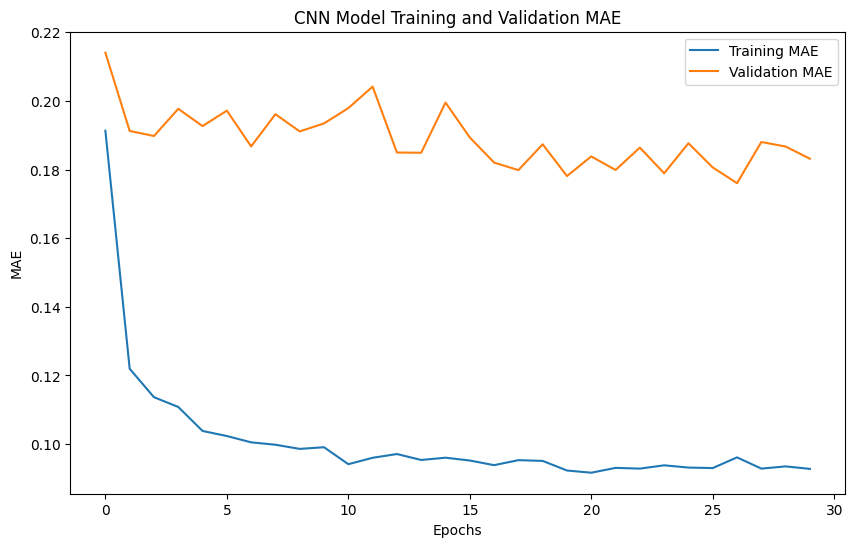

In [52]:
# Plot MAE during training
plt.figure(figsize=(10, 6))
plt.plot(cnn_hist.history['mean_absolute_error'], label='Training MAE')
plt.plot(cnn_hist.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('CNN Model Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

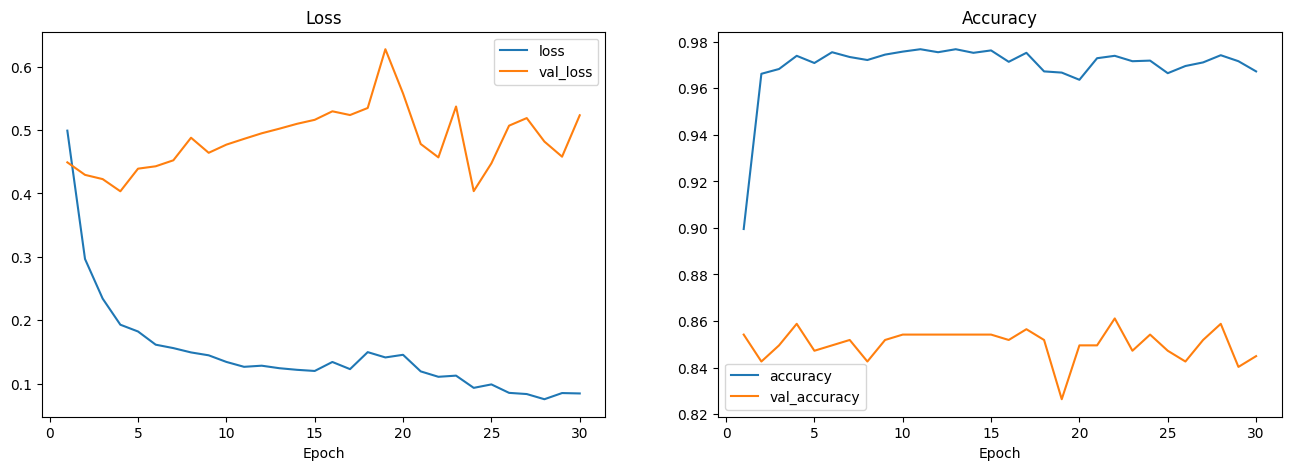

In [53]:
# history plot model
epoch = 30

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].plot(range(1, epoch + 1), history_updated.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), history_updated.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch + 1), history_updated.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), history_updated.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

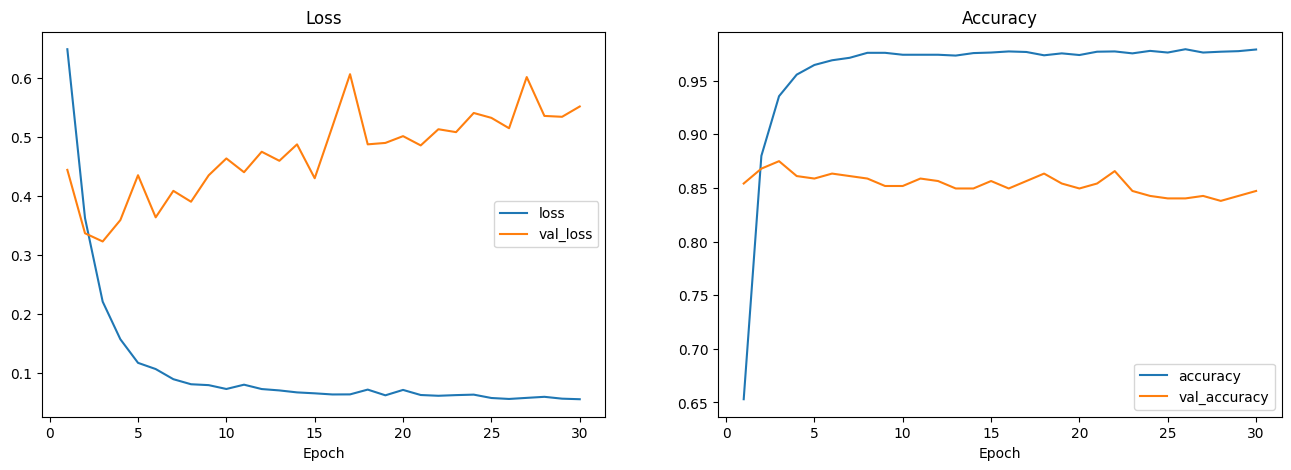

In [54]:
# history plot model
epoch = 30

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].plot(range(1, epoch + 1), lstm_hist.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), lstm_hist.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch + 1), lstm_hist.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), lstm_hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()


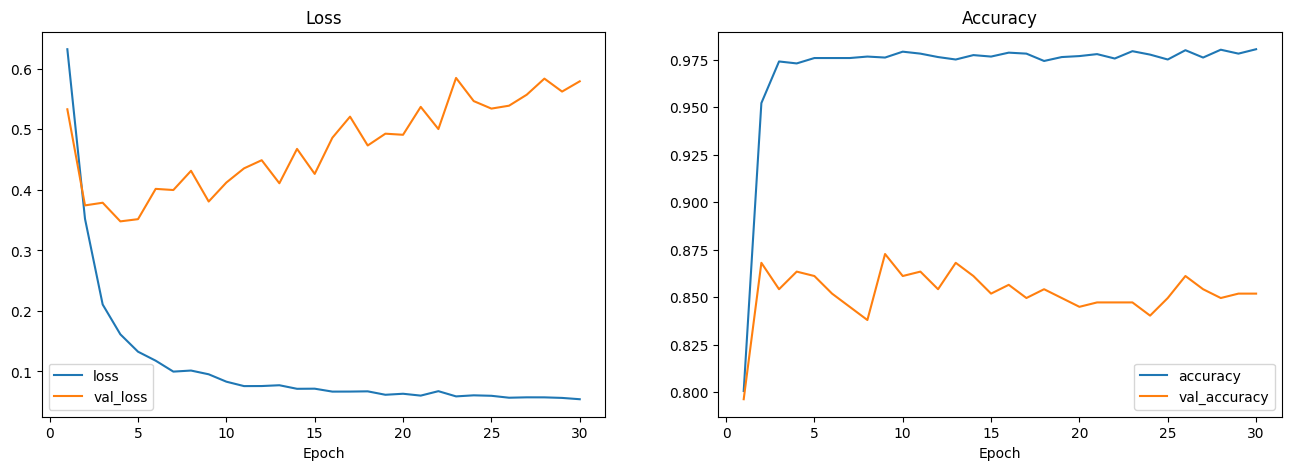

In [55]:
# history plot model
epoch = 30

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].plot(range(1, epoch + 1), lstm_hist2.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), lstm_hist2.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch + 1), lstm_hist2.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), lstm_hist2.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()


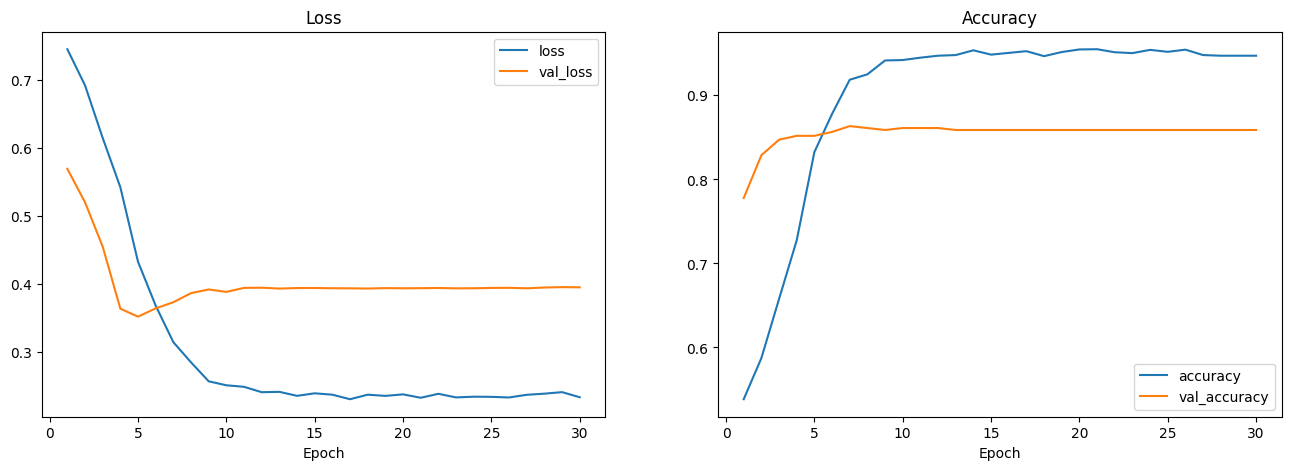

In [56]:
# history plot model
epoch = 30

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].plot(range(1, epoch + 1), rnn_hist.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), rnn_hist.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch + 1), rnn_hist.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), rnn_hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()


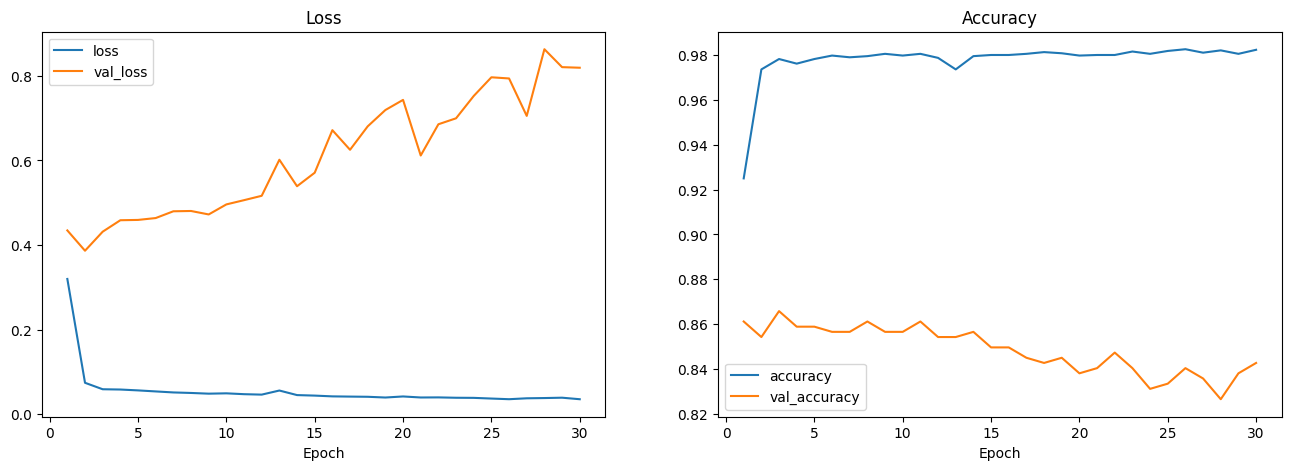

In [57]:
# history plot model
epoch = 30

fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].plot(range(1, epoch + 1), gru_hist.history['loss'], label='loss')
ax[0].plot(range(1, epoch + 1), gru_hist.history['val_loss'], label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1, epoch + 1), gru_hist.history['accuracy'], label='accuracy')
ax[1].plot(range(1, epoch + 1), gru_hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()


# Model Evaluation on Test

In [58]:
# Evaluasi model LSTM 1 pada test set
result_lstm1 = lstm_1.evaluate(X_test,y_test)

34/34 [==============================] - 0s 13ms/step - loss: 0.6791 - accuracy: 0.8656


In [59]:
# Evaluasi model LSTM 1 pada test set
result_lstm2 = lstm_2.evaluate(X_test,y_test)

34/34 [==============================] - 0s 10ms/step - loss: 0.6395 - accuracy: 0.8591


In [60]:
# Evaluasi model Simple RNN pada test set
result_rnn = rnn.evaluate(X_test,y_test)

34/34 [==============================] - 0s 10ms/step - loss: 0.3667 - accuracy: 0.8563


In [61]:
# Evaluasi model GRU pada test set
result_gru = gru.evaluate(X_test,y_test)

34/34 [==============================] - 1s 14ms/step - loss: 0.9375 - accuracy: 0.8563


In [62]:
result_lstm_update = lstm_further_updated.evaluate(X_test,y_test)

34/34 [==============================] - 0s 10ms/step - loss: 0.5564 - accuracy: 0.8508


In [63]:
# Memprediksi X test
y_test_pred = lstm_2.predict(X_test)

34/34 [==============================] - 3s 10ms/step


In [64]:
# Mengubah hasil prediksi dari probabilitas menjadi kelas 0 atau 1
y_test_pred_final = np.where(y_test_pred > 0.5, 1, 0)

Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       564
           1       0.90      0.79      0.84       515

    accuracy                           0.86      1079
   macro avg       0.86      0.86      0.86      1079
weighted avg       0.86      0.86      0.86      1079


Confusion Matrix      : 


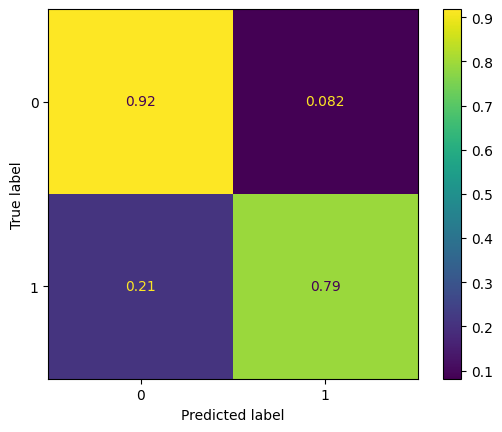

In [65]:
# Classification Report dari Test Set
print('Classification Report : \n', classification_report(y_test, y_test_pred_final))
print('')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                                                            y_pred=y_test_pred_final,
                                                                            normalize='true'))

# Model Saving

melakukan save model yang terbaik dalam bentuk file zip

In [66]:
# Zip model rnn

!zip -r /content/model_rnn.zip /content/model_rnn
!zip -r /content/model_lstm_2.zip /content/model_lstm_2

  adding: content/model_rnn/ (stored 0%)
  adding: content/model_rnn/saved_model.pb (deflated 90%)
  adding: content/model_rnn/keras_metadata.pb (deflated 93%)
  adding: content/model_rnn/fingerprint.pb (stored 0%)
  adding: content/model_rnn/variables/ (stored 0%)
  adding: content/model_rnn/variables/variables.index (deflated 69%)
  adding: content/model_rnn/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/model_rnn/assets/ (stored 0%)
  adding: content/model_lstm_2/ (stored 0%)
  adding: content/model_lstm_2/saved_model.pb (deflated 90%)
  adding: content/model_lstm_2/keras_metadata.pb (deflated 93%)
  adding: content/model_lstm_2/fingerprint.pb (stored 0%)
  adding: content/model_lstm_2/variables/ (stored 0%)
  adding: content/model_lstm_2/variables/variables.index (deflated 67%)
  adding: content/model_lstm_2/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/model_lstm_2/assets/ (stored 0%)


In [67]:
# Menyimpan list stopwords
with open('stopwords.txt', 'w') as file:
    json.dump(list(stopwords_id), file)

kode diatas adalah untuk menyimpan kata-kata yang ada di stopword kedalam file txt

In [74]:
model = load_model('model_lstm_2')
model_rnn = load_model('model_rnn')
# Load stopwords
with open('stopwords.txt', 'r') as sw:
    stopwords = json.load(sw)
stopwords = set(stopwords)

# Model Inference

In [105]:
# Membuat dataframe inference
inf = [
    "alhamdulillah bahan baju nyaman dan terjamin bagus",
    "baju jelek bahan tipis",
    "pengiriman cepat",
    "kualitas nyaman dan bagus",
    "baju ini mudah sobek dan rusak"
]

inf_df = pd.DataFrame(inf, columns=['customer_review'])
inf_df

,customer_review
0,alhamdulillah bahan baju nyaman dan terjamin b...
1,baju jelek bahan tipis
2,pengiriman cepat
3,kualitas nyaman dan bagus
4,baju ini mudah sobek dan rusak


In [106]:
# Mendefinisikan lemmatizer
lemmatizer = Lemmatizer()

In [107]:
# Text Pre-processing
inf_df['customer_review'] = inf_df.apply(lambda row: text_preprocessing(row['customer_review'], stopwords, lemmatizer), axis=1)
inf_df

,customer_review
0,bahan baju nyaman jamin
1,baju jelek bahan tipis
2,cepat
3,kualitas nyaman
4,baju mudah sobek rusak


In [108]:
# Prediksi data inference
y_pred = model.predict(inf_df)

1/1 [==============================] - 0s 111ms/step


In [109]:
# Mengubah hasil probabilitas menjadi kelas 1 atau 0, di mana 1: recommended dan 0: not recommended
y_pred_final = np.where(y_pred > 0.5, 1, 0)
inf_df['sentiment_encode'] = y_pred_final
inf_df

,customer_review,sentiment_encode
0,bahan baju nyaman jamin,1
1,baju jelek bahan tipis,0
2,cepat,1
3,kualitas nyaman,1
4,baju mudah sobek rusak,0


# Kesimpulan

Dari tujuan awal mengembangkan model NLP untuk mengklasifikasikan sentimen ulasan produk, model RNN muncul sebagai pemenang dengan tingkat akurasi sebesar 88%. Keberhasilan ini sesuai dengan tujuan penggunaan metrik akurasi sebagai tolok ukur utama dalam mengevaluasi performa model. Ini menegaskan bahwa pendekatan yang diambil dalam membangun model RNN memberikan hasil yang sangat baik dalam mengklasifikasikan sentimen ulasan produk secara akurat. Hasil ini memberikan dasar yang kuat untuk memahami pandangan dan perasaan pengguna terhadap produk dengan tingkat keakuratan yang tinggi.